In [57]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [58]:
# Path to the JSONL file
WORDs = ["Acknowledgement", "Subdermatoglyphic", "Acknowledgement", "Subdermatoglyphic"]
GPT4Outputs = [
    "./jsons/batch_KHkGXCNId6ku0zrUlf2hqp2z_output.jsonl",
    "./jsons/batch_Y4i1DdveQxt39eW5VoU51ntQ_output.jsonl",
    "./jsons/batch_GTAz88LUTeB0h59quW0lyjrV_output.jsonl",
    "./jsons/batch_1PtVBYhjBcrVwC2McjtjSefv_output.jsonl",
]

index = 1
WORD = WORDs[index]
file_path = GPT4Outputs[index]

gt_data = pd.read_json(f"./{WORD}/configurations.json")

In [59]:
# Dictionary to map custom_id to message content
custom_id_to_content = {}

# Open the file and read line by line
with open(file_path, "r") as file:
    for line in file:
        json_obj = json.loads(line)
        # Extract custom_id and message content
        custom_id = json_obj.get("custom_id")
        message_content = json_obj["response"]["body"]["choices"][0]["message"][
            "content"
        ]
        # Map custom_id to message content
        if custom_id:
            custom_id_to_content[custom_id] = message_content

# Print the dictionary to verify
print(len(custom_id_to_content))

408


In [60]:
# let's reformat keys, split with "uid__" and keep the last part
custom_id_to_content = {
    key.split("uid__")[-1]: value for key, value in custom_id_to_content.items()
}

# for the values, let's geet the text inside " and " ) and ignore if there is no "
custom_id_to_content = {
    key: value.split('"')[1] if '"' in value else value
    for key, value in custom_id_to_content.items()
}

# rmemove . and turn lower case and if the reaming
custom_id_to_content = {
    key: value.lower().replace(".", "").strip()
    for key, value in custom_id_to_content.items()
}

# remove items with value longer than 1
custom_id_to_content = {
    key: value for key, value in custom_id_to_content.items() if len(value) == 1
}


# Convert the dictionary to a DataFrame
custom_id_df = pd.DataFrame(
    list(custom_id_to_content.items()), columns=["image_path", "predicted"]
)

# Merge with gt_data on the image_path column
combined_data = pd.merge(gt_data, custom_id_df, on="image_path", how="inner")

# Remove rows where the 'predicted' column has missing values
cleaned_data = combined_data.dropna(subset=["predicted"])
cleaned_data["gt"] = cleaned_data.apply(
    lambda row: row["word"][row["circle_index"]].lower(), axis=1
)

# Display the combined DataFrame
cleaned_data

,word,font_path,circle_index,thickness,scale_factor,padding,x_offset,y_offset,canvas_width,canvas_height,final_width,final_height,image_path,predicted,gt
0,Subdermatoglyphic,fonts/Helvetica.ttf,0,2,1.4,25,0,0,10,2,512,512,Subdermatoglyphic/text_image_16b1282e-e4f4-4fb...,s,s
1,Subdermatoglyphic,fonts/Helvetica.ttf,0,2,1.4,50,0,0,10,2,512,512,Subdermatoglyphic/text_image_3eb19048-2162-4e5...,s,s
2,Subdermatoglyphic,fonts/Helvetica.ttf,0,2,1.4,100,0,0,10,2,512,512,Subdermatoglyphic/text_image_1619bd61-3dbe-45c...,s,s
3,Subdermatoglyphic,fonts/Helvetica.ttf,0,2,1.4,200,0,0,10,2,512,512,Subdermatoglyphic/text_image_fe2c8cf6-fb57-4e7...,s,s
4,Subdermatoglyphic,fonts/Helvetica.ttf,0,3,1.4,25,0,0,10,2,512,512,Subdermatoglyphic/text_image_c5dcbbd8-e252-4ae...,s,s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,Subdermatoglyphic,"fonts/OpenSans-VariableFont_wdth,wght.ttf",16,3,1.4,200,0,0,10,2,512,512,Subdermatoglyphic/text_image_32d6911b-0051-458...,c,c
402,Subdermatoglyphic,"fonts/OpenSans-VariableFont_wdth,wght.ttf",16,4,1.4,25,0,0,10,2,512,512,Subdermatoglyphic/text_image_e89f5d1d-aee9-42a...,c,c
403,Subdermatoglyphic,"fonts/OpenSans-VariableFont_wdth,wght.ttf",16,4,1.4,50,0,0,10,2,512,512,Subdermatoglyphic/text_image_c9acefda-3433-4f5...,c,c
404,Subdermatoglyphic,"fonts/OpenSans-VariableFont_wdth,wght.ttf",16,4,1.4,100,0,0,10,2,512,512,Subdermatoglyphic/text_image_6872db0e-9db0-404...,c,c


In [61]:
cleaned_data["is_prediction_correct"] = cleaned_data["gt"] == cleaned_data["predicted"]
# get accuracy
accuracy = cleaned_data["is_prediction_correct"].mean()
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

Overall Accuracy: 72.41%


In [62]:
errors = cleaned_data[cleaned_data["is_prediction_correct"] == False]
common_errors = (
    errors.groupby(["predicted", "gt"])
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
)
print(common_errors.head(10))

   predicted gt  count
18         o  p     13
17         o  l     13
19         o  r     10
9          g  l      7
22         p  h      6
21         o  y      6
23         p  y      6
20         o  t      5
29         y  l      4
16         o  i      4


/var/folders/y1/b5wjnkp96_b7cvzncx0zsry40000gn/T/ipykernel_6703/24165238.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/y1/b5wjnkp96_b7cvzncx0zsry40000gn/T/ipykernel_6703/24165238.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/y1/b5wjnkp96_b7cvzncx0zsry40000gn/T/ipykernel_6703/24165238.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(list("Subdermatoglyphic"))
/var/folders/y1/b5wjnkp96_b7cvzncx0zsry40000gn/T/ipykernel_6703/24165238.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.1

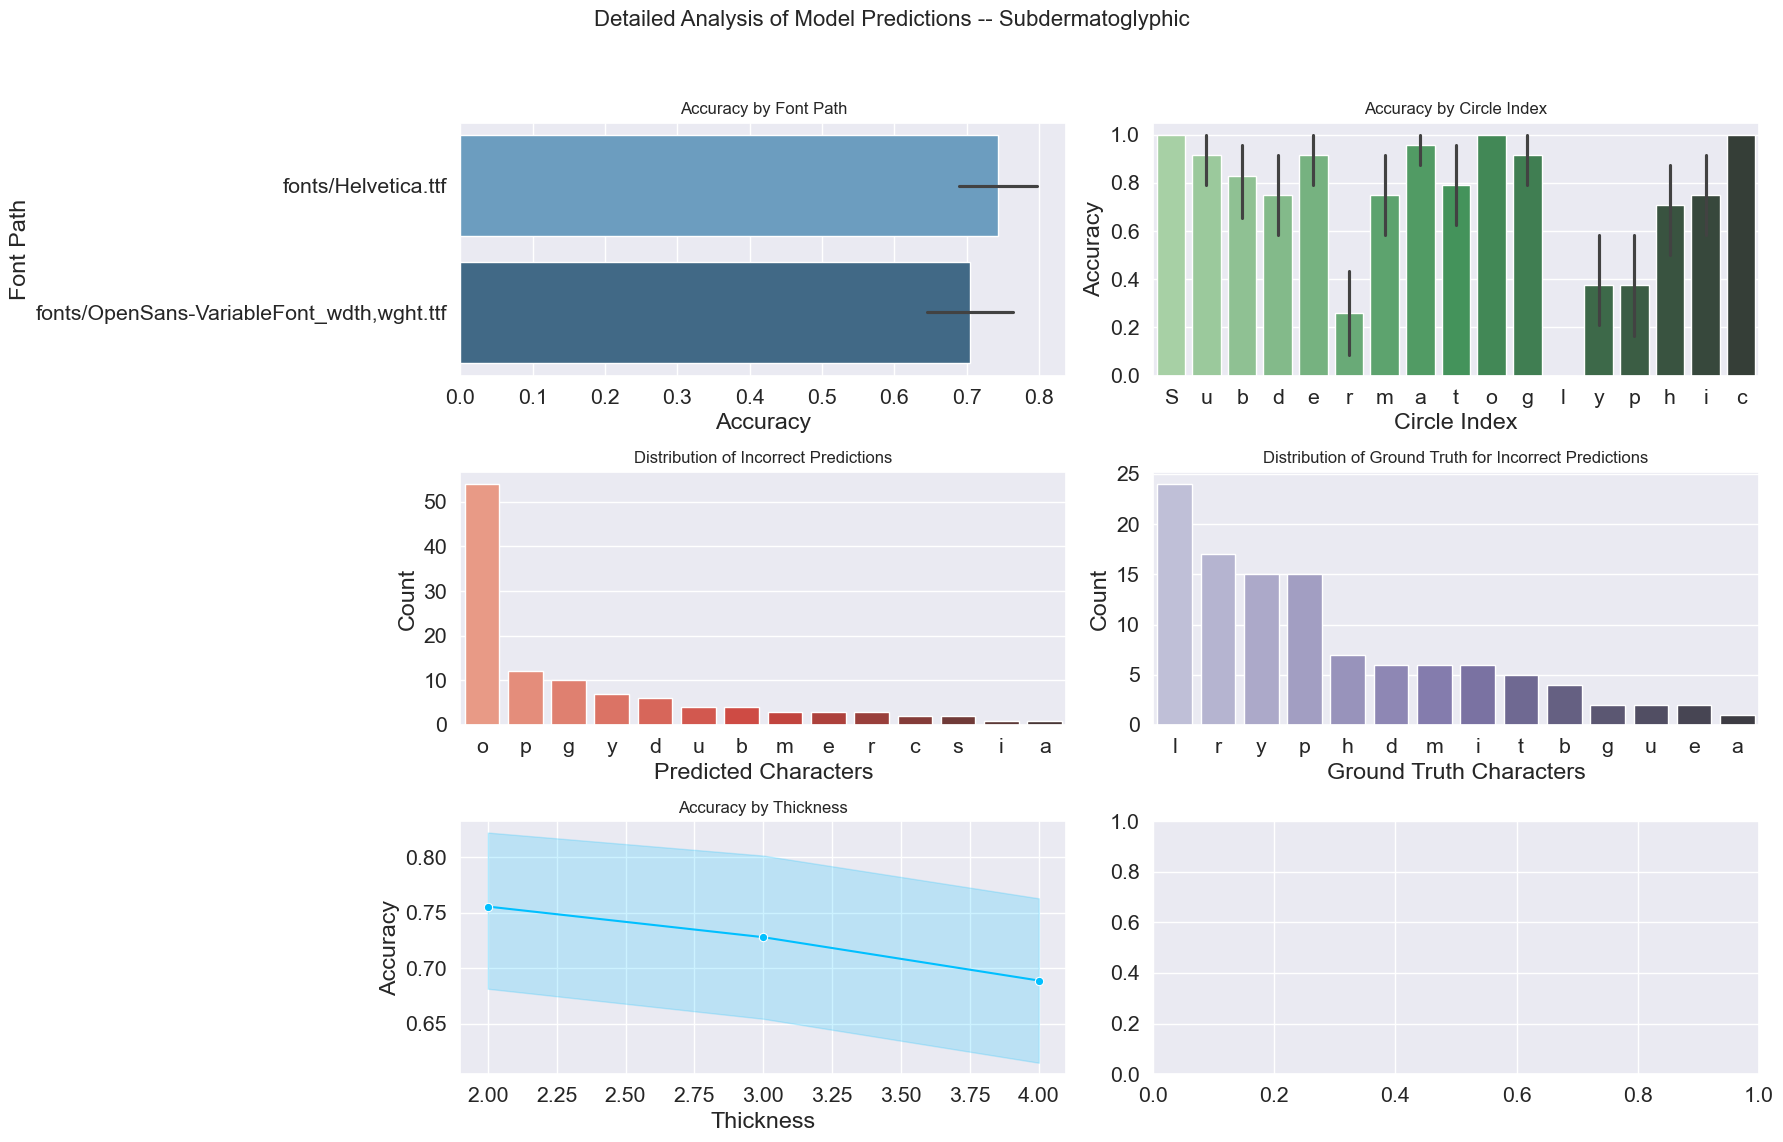

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure with a more professional color palette and layout
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
fig.suptitle(f"Detailed Analysis of Model Predictions -- {WORD}", fontsize=16)

# Customize the color palette
sns.set(style="whitegrid", palette="muted")

# Plot Accuracy by Font Path
sns.barplot(
    ax=axes[0, 0],
    x="is_prediction_correct",
    y="font_path",
    data=cleaned_data,
    estimator=lambda x: x.mean(),
    palette="Blues_d",
)
axes[0, 0].set_title("Accuracy by Font Path")
axes[0, 0].set_xlabel("Accuracy")
axes[0, 0].set_ylabel("Font Path")

# Plot Accuracy by Circle Index
sns.barplot(
    ax=axes[0, 1],
    x="circle_index",
    y="is_prediction_correct",
    data=cleaned_data,
    estimator=lambda x: x.mean(),
    palette="Greens_d",
)
axes[0, 1].set_title("Accuracy by Circle Index")
axes[0, 1].set_xlabel("Circle Index")
axes[0, 1].set_ylabel("Accuracy")
# Set x-axis labels to characters from the word
axes[0, 1].set_xticklabels(list("Subdermatoglyphic"))


# Plot Distribution of Incorrect Predictions
sns.countplot(
    ax=axes[1, 0],
    x="predicted",
    data=errors,
    order=errors["predicted"].value_counts().index,
    palette="Reds_d",
)
axes[1, 0].set_title("Distribution of Incorrect Predictions")
axes[1, 0].set_xlabel("Predicted Characters")
axes[1, 0].set_ylabel("Count")

# Plot Distribution of Ground Truth for Incorrect Predictions
sns.countplot(
    ax=axes[1, 1],
    x="gt",
    data=errors,
    order=errors["gt"].value_counts().index,
    palette="Purples_d",
)
axes[1, 1].set_title("Distribution of Ground Truth for Incorrect Predictions")
axes[1, 1].set_xlabel("Ground Truth Characters")
axes[1, 1].set_ylabel("Count")

# Plot Accuracy by Thickness
sns.lineplot(
    ax=axes[2, 0],
    x="thickness",
    y="is_prediction_correct",
    data=cleaned_data,
    estimator=lambda x: x.mean(),
    marker="o",
    color="deepskyblue",
)
axes[2, 0].set_title("Accuracy by Thickness")
axes[2, 0].set_xlabel("Thickness")
axes[2, 0].set_ylabel("Accuracy")


plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust subplots to fit into figure area.
plt.show()

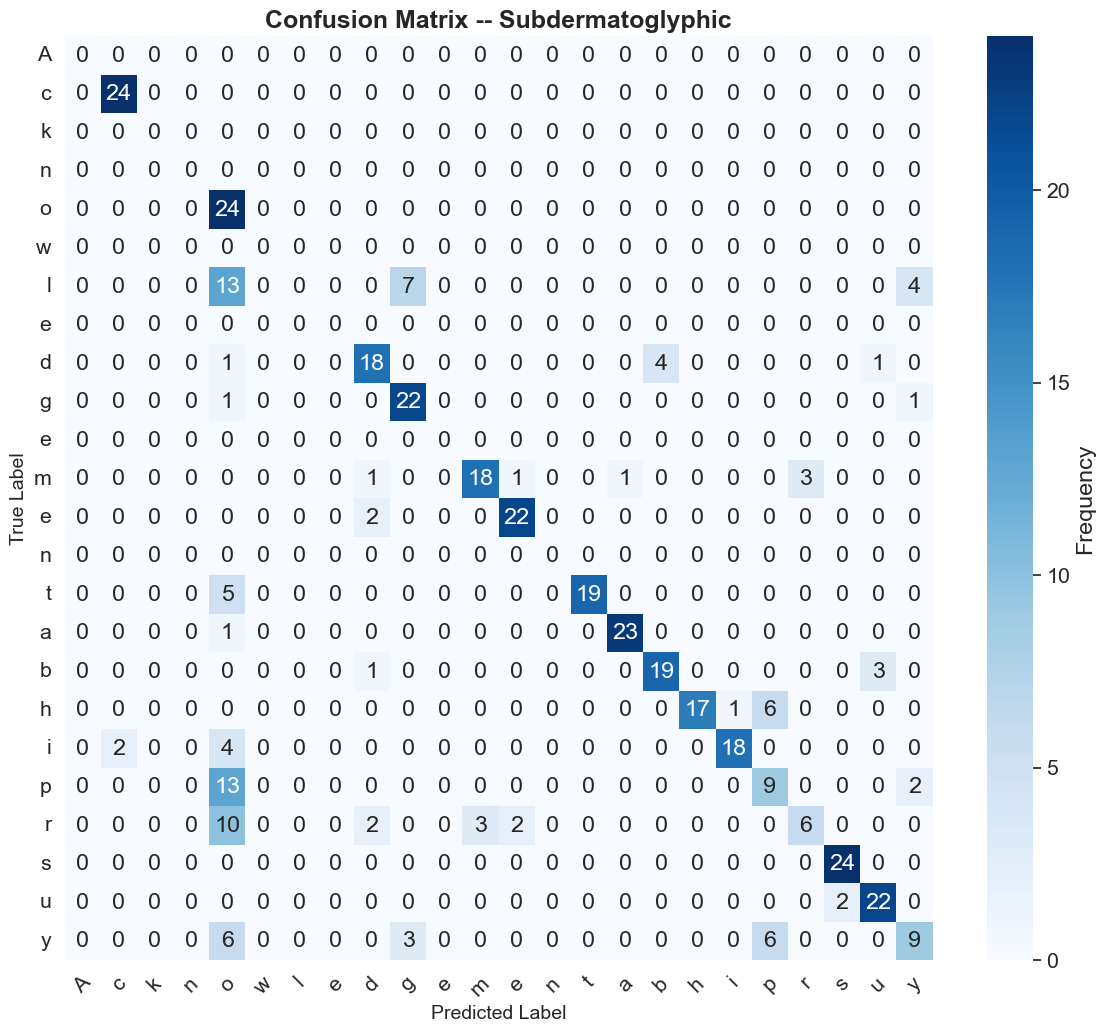

In [64]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Extract ground truth and predictions
ground_truth = cleaned_data["gt"]
predictions = cleaned_data["predicted"]

# Define the order of labels based on the word "Acknowledgement" and any extra characters
desired_order = list(
    "Acknowledgement"
)  # Ensure it's in lowercase if your data is in lowercase
all_labels = np.unique(np.concatenate((ground_truth, predictions)))
extra_labels = [label for label in all_labels if label not in desired_order]
final_labels = desired_order + extra_labels

# Create the confusion matrix with the specified label order
conf_matrix = confusion_matrix(ground_truth, predictions, labels=final_labels)

# Plot the confusion matrix with a more professional appearance
plt.figure(figsize=(14, 12))
sns.set(font_scale=1.4)  # Increase font size for readability
heatmap = sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=final_labels,
    yticklabels=final_labels,
    cbar_kws={"label": "Frequency"},
)
plt.title(f"Confusion Matrix -- {WORD}", fontsize=18, fontweight="bold")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()